In [1]:
import os
import random
import numpy as np
import pandas as pd
import sys
import sklearn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from summa import keywords
import wikipedia
import spacy
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [2]:
text_data=pd.read_csv('speech100.csv')

# NMF with Frobenius norm

In [3]:
n_samples = 2000
n_features = 1000
n_components = 6
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, n_components, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_features=n_features)

tfidf = tfidf_vectorizer.fit_transform(text_data['clean'])


Extracting tf-idf features for NMF...


C:\Users\rebeccalai\anaconda3\envs\tensorflow\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\rebeccalai\anaconda3\envs\tensorflow\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\rebeccalai\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


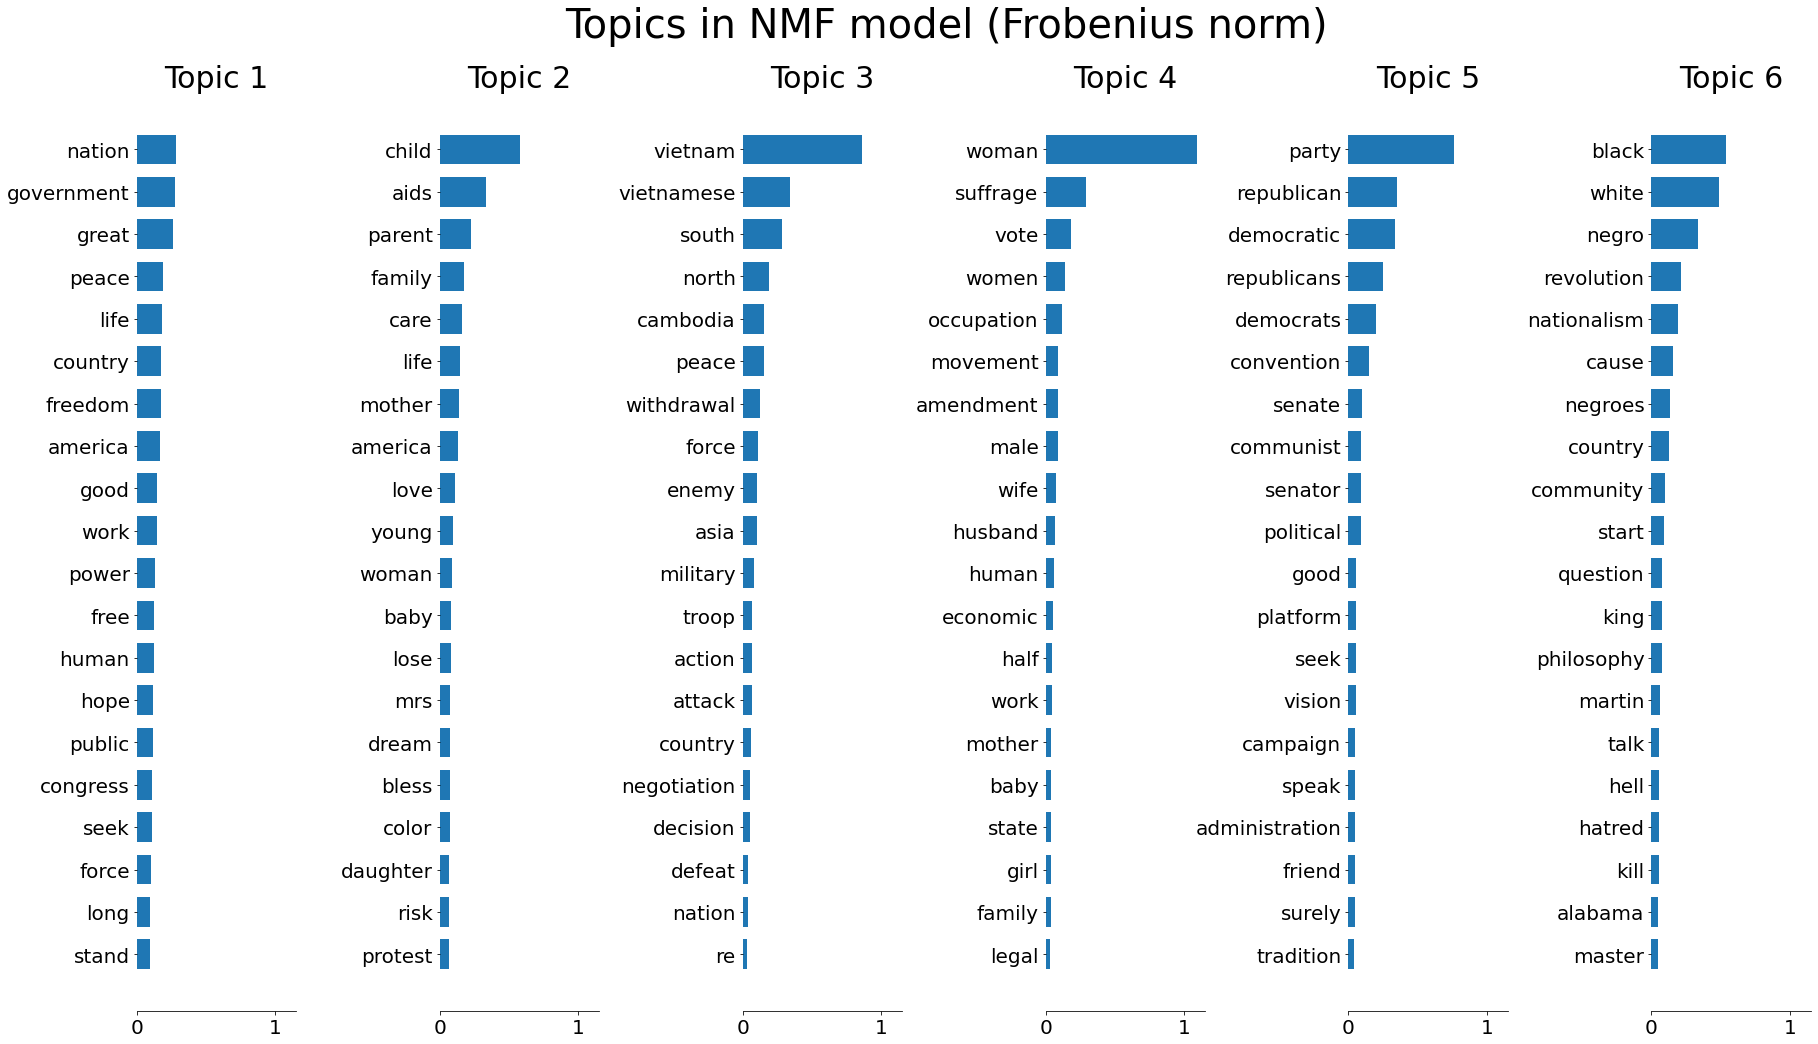

In [4]:
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

In [5]:
w=nmf.fit_transform(tfidf)
topic_doc=np.argmax(w, axis=1)
topic_doc
unique, counts = np.unique(topic_doc, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0 70]
 [ 1  6]
 [ 2  5]
 [ 3  7]
 [ 4  7]
 [ 5  5]]


C:\Users\rebeccalai\anaconda3\envs\tensorflow\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\rebeccalai\anaconda3\envs\tensorflow\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


**Model分布非常不均衡排列**

In [6]:
keywords_topic = []
for j in range(n_components):
    keywords_topic.append(keywords.keywords(" ".join([i for i in text_data['clean'][(topic_doc==j).tolist()]]),words=50).split('\n'))

In [8]:
for j in range(n_components):
    print("topic",j+1,":",keywords_topic[j],"\n")

topic 1 : ['nation', 'nations', 'national', 'nationally', 'nationalism', 'nationality', 'nationalization', 'great', 'greatly', 'greatness', 'government', 'govern', 'governments', 'governing', 'governed', 'country', 'life', 'good', 'goodness', 'goodly', 'work', 'working', 'powerful', 'powerfully', 'powers', 'peace', 'peaceful', 'peacefully', 'americas', 'america', 'human', 'humanity', 'humane', 'humanize', 'public', 'publication', 'publicly', 'publicity', 'freedom', 'hand power', 'state', 'stately', 'free', 'stand', 'standing', 'political', 'politics', 'politically', 'politic', 'friendly', 'friends', 'congress', 'force', 'forces', 'forcefully', 'forcing', 'hope', 'hopeful', 'word place friend', 'long', 'longing', 'handful', 'hands', 'child', 'fact', 'seek', 'constitution', 'constitutional', 'constitute', 'constitutionally', 'constitutionality', 'question', 'questioning', 'questioner', 'questionable', 'money', 'history', 'meet', 'meeting', 'city', 'cities', 'purpose', 'family', 'words', 

In [9]:
for j in range(n_components):
    print("Topic",j,":",text_data['Year'][np.where(topic_doc==j)[0]].tolist(),"\n")

Topic 0 : [1961, 1933, 1941, 1952, 1986, 1960, 1965, 1984, 1984, 1974, 1951, 1968, 1906, 1961, 1917, 1962, 1963, 1900, 1964, 1934, 1940, 1983, 1981, 1933, 1947, 1950, 1918, 1953, 1963, 1988, 1974, 1918, 1941, 1900, 1963, 1962, 1969, 1988, 1964, 1947, 1983, 1948, 1984, 1917, 1984, 1984, 1969, 1937, 1964, 1917, 1961, 1968, 1991, 1919, 1939, 1932, 1913, 1964, 1920, 1935, 1974, 1968, 1979, 1987, 1999, 1974, 1919, 1963, 1948, 1966] 

Topic 1 : [1924, 1990, 1992, 1992, 1925, 1995] 

Topic 2 : [1969, 1967, 1970, 1968, 1971] 

Topic 3 : [1915, 1995, 1916, 1917, 1983, 1920, 1970] 

Topic 4 : [1976, 1950, 1952, 1948, 1980, 1952, 1954] 

Topic 5 : [1963, 1964, 1968, 1966, 1963] 



# LDA

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from nltk.stem import *
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer 
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk import word_tokenize

In [18]:
processed_docs=[]
for i in range(0,100):
    processed_docs.append(word_tokenize(text_data["clean"][i]))

dictionary = gensim.corpora.Dictionary(processed_docs)  # Bag of words
dictionary.filter_extremes(no_below=2, no_above=0.8)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# iteration  - get the best parameters
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, start=3, limit=8, step=1)


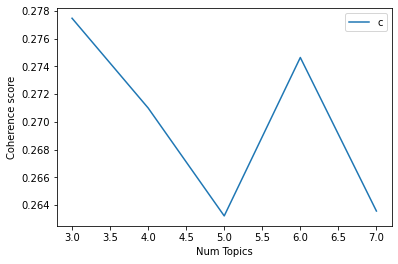

In [16]:
# Show graph
limit=8; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**num_topics=6  Best is the 6 topics**

In [19]:
num_topics=6  #best is the 6 topics
# running LDA
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics =6, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2,random_state=123)

# The output from the model is  9  topics each categorized by a series of words
print(lda_model.print_topics())

# Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.011*"peace" + 0.009*"government" + 0.008*"vietnam" + 0.005*"america" + 0.005*"south" + 0.005*"freedom" + 0.005*"hope" + 0.005*"force" + 0.004*"power" + 0.004*"party"'), (1, '0.010*"white" + 0.010*"black" + 0.009*"public" + 0.007*"question" + 0.005*"child" + 0.005*"america" + 0.004*"bank" + 0.004*"television" + 0.004*"woman" + 0.004*"society"'), (2, '0.014*"woman" + 0.006*"government" + 0.005*"money" + 0.005*"party" + 0.004*"child" + 0.004*"human" + 0.004*"friend" + 0.003*"wealth" + 0.003*"rich" + 0.003*"political"'), (3, '0.007*"america" + 0.007*"woman" + 0.006*"child" + 0.006*"human" + 0.005*"senator" + 0.005*"family" + 0.004*"young" + 0.004*"stand" + 0.004*"hope" + 0.004*"government"'), (4, '0.017*"government" + 0.010*"power" + 0.009*"congress" + 0.008*"woman" + 0.008*"vote" + 0.006*"peace" + 0.006*"duty" + 0.005*"force" + 0.005*"citizen" + 0.005*"constitution"'), (5, '0.009*"freedom" + 0.008*"white" + 0.007*"church" + 0.007*"revolution" + 0.007*"government" + 0.007*"black" +

In [20]:
## Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models  as gensim_models
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, bow_corpus, dictionary)
vis

C:\Users\rebeccalai\anaconda3\envs\tensorflow\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005729  0.049882       1        1  26.973129
2     -0.039898 -0.106856       2        1  18.216759
5      0.062022  0.019196       3        1  14.722648
4     -0.122699  0.043837       4        1  14.694635
3      0.038643 -0.021387       5        1  14.261104
1      0.067661  0.015327       6        1  11.131725, topic_info=            Term        Freq       Total Category  logprob  loglift
15         black  219.000000  219.000000  Default  30.0000  30.0000
313        white  262.000000  262.000000  Default  29.0000  29.0000
1675       woman  528.000000  528.000000  Default  28.0000  28.0000
1667     vietnam  214.000000  214.000000  Default  27.0000  27.0000
506   revolution  122.000000  122.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
268        state   29.265265  259.944612   Topic6  -5.8543   0.0113
767    political   28.428367  266.053125   Topic6  -5.8833  -0.0409
783      program   25.472394  149.872875   Topic6  -5.9931   0.4232
473        party   28.597431  330.719898   Topic6  -5.8774  -0.2526
436        human   26.724111  337.275324   Topic6  -5.9451  -0.3400

[482 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4361      3  0.905588  abortion
4361      5  0.082326  abortion
580       1  0.549220    action
580       2  0.063129    action
580       3  0.195699    action
...     ...       ...       ...
574       3  0.070685     young
574       4  0.048936     young
574       5  0.320800     young
574       6  0.070685     young
4794      6  0.834062    youre

[1354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 6, 5, 4, 2])

**明显分的不如NMF好**

In [21]:
# 分配给每个题目话题
def get_lda_topics(model, num_topics):
    """Print lda topics with pd.DataFrame"""
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 16)
        word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
        
    return pd.DataFrame(word_dict).transpose()

get_lda_topics(lda_model, num_topics)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Topic #01,peace,government,vietnam,america,south,freedom,hope,force,power,party,seek,military,free,national,action,program
Topic #02,white,black,public,question,child,america,bank,television,woman,society,problem,start,power,talk,build,national
Topic #03,woman,government,money,party,child,human,friend,wealth,rich,political,young,prove,stand,communist,dollar,social
Topic #04,america,woman,child,human,senator,family,young,stand,hope,government,state,freedom,love,public,fellow,berlin
Topic #05,government,power,congress,woman,vote,peace,duty,force,citizen,constitution,purpose,question,republic,free,declare,object
Topic #06,freedom,white,church,revolution,government,black,negro,human,america,political,abortion,problem,state,community,public,party


In [22]:
# get topis for the all speech  归属每个题目的概率分布
all_topics = lda_model.get_document_topics(bow_corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
all_topics_df.rename(columns=lambda x:x+1, inplace=True)
all_topics_df

,1,2,3,4,5,6
0,0.000327,0.000326,0.000327,0.000327,0.000326,0.998367
1,0.998046,0.000390,0.000391,0.000391,0.000391,0.000391
2,0.914410,0.000267,0.000267,0.000267,0.084522,0.000267
3,0.761236,0.000959,0.000961,0.000961,0.234924,0.000959
4,0.038971,0.000306,0.000306,0.000306,0.000306,0.959805
...,...,...,...,...,...,...
95,0.998269,0.000346,0.000346,0.000347,0.000346,0.000346
96,0.000398,0.000397,0.000398,0.998013,0.000397,0.000397
97,0.000317,0.000316,0.630694,0.001029,0.048349,0.319294
98,0.133189,0.000136,0.000136,0.725096,0.000136,0.141307


In [23]:
# 得到每一行中最大的概率就是topic
lda_topic=all_topics_df.idxmax(1).to_list()
text_data["LDA_topic"]=lda_topic
sub_df=text_data.loc[text_data["LDA_topic"]==1]

,Unnamed: 0,Title,Lecturer,Year,Doc,clean,profession,gender,party,age_then,LDA_topic
1,1,Inaugural Address,John Fitzgerald Kennedy,1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",vice johnson speaker chief justice eisenhower ...,35th U.S. President,male,Null,44,1
2,2,First Inaugural Address-Franklin Delano Roosevelt,Franklin Delano Roosevelt,1933,"President Hoover, Mr. Chief Justice, my friend...",hoover chief justice friend national consecrat...,32nd U.S. President,male,Democratic,51,1
3,3,Pearl Harbor Address to the Nation,Franklin Delano Roosevelt,1941,"Mr. Vice President, Mr. Speaker, Members of th...",vice speaker members senate house representati...,32nd U.S. President,male,Democratic,59,1
7,7,Shuttle 'Challenger' Disaster Address,Ronald Wilson Reagan,1986,"Ladies and Gentlemen, Id planned to speak to y...",ladies gentlemen plan speak report state union...,40th U.S. President,male,Republican,75,1
10,10,1984 DNC Keynote Address,Mario Matthew Cuomo,1984,Thank you very much. On behalf of the great Em...,behalf great empire state family york great p...,Former Governor of New York,male,Democratic,52,1
11,11,1984 DNC Address,Jesse Louis Jackson,1984,Tonight we come together bound by our faith in...,bind faith mighty genuine respect love country...,"Former Shadow US Senator, DC",male,Null,43,1
13,13,Farewell Address to Congress,(Gen) Douglas MacArthur,1951,"Mr. President, Mr. Speaker, and Distinguished ...",speaker distinguished members congress stand r...,American military leader,male,Null,71,1
17,17,Farewell Address,Dwight David Eisenhower,1961,"Good evening, my fellow Americans. First, I sh...",good evening fellow express gratitude radio te...,34th U.S. President,male,Null,71,1
20,20,The Great Silent Majority,Richard Milhous Nixon,1969,"Good evening, my fellow Americans. Tonight I w...",good evening fellow talk subject deep concern ...,37th U.S. President,male,Republican,56,1
24,24,A Time for Choosing,Ronald Wilson Reagan,1964,Reagan: Thank you. Thank you very much. Thank ...,reagan good evening sponsor identify televisi...,40th U.S. President,male,Republican,53,1


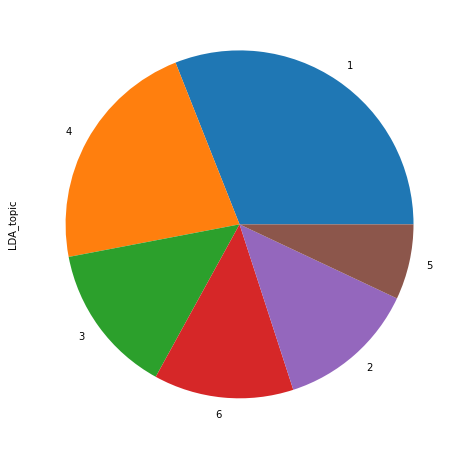

In [24]:
plt.rcParams['figure.figsize'] = [20, 8]
text_data.LDA_topic.value_counts().plot(kind='pie')
plt.show()